In [ ]:
import pandas as pd
excel_data = pd.ExcelFile("Districtwise_Crime_of_India_2001_to_2014.xlsx")

sheet_names = excel_data.sheet_names
sheet_names

['Sheet1']

**Data Cleaning Summary**

1.Removed rows with missing districts and excluded "TOTAL"/summary rows to avoid duplication.

2.Normalized column names (uppercase, stripped spaces/newlines) for consistency.

3.Standardized state names using a mapping to match across datasets and GeoJSON.

4.Merged Telangana with Andhra Pradesh under "COMBINED_TELANGANA" to ensure continuity.

5.Dropped non-district level rows before modeling and visualization.

6.Aggregated data by year and district for time-series analysis and forecasting.

7.Ensured numeric columns were clean and free of missing or inconsistent values.


#**EDA / CLEANING**

##**Question 1** Determine the total number of crimes recorded across all districts and the average number of murders per district.

In [ ]:
df = excel_data.parse('Sheet1')
df.columns = df.columns.str.strip().str.upper().str.replace("\n", " ").str.replace(" +", " ", regex=True)

df_clean = df[df["DISTRICT"].notna()].copy()
df_clean = df_clean[~df_clean["DISTRICT"].str.upper().str.contains("TOTAL")]

total_crimes = df_clean["TOTAL IPC CRIMES"].sum()

murders_per_district = df_clean.groupby("DISTRICT")["MURDER"].sum()
average_murders = murders_per_district.mean()

print("Total IPC Crimes (All Districts, All Years):", total_crimes)
print("Average Murders per District (All Years):", average_murders)


Total IPC Crimes (All Districts, All Years): 29447315
Average Murders per District (All Years): 493.5693277310924


Between 2001 and 2014, a total of 29,447,315 IPC crimes were recorded across all districts in India. On average, each district reported around 493 murders over this 14-year period. These figures highlight the scale of criminal activity nationwide and suggest that while certain regions may contribute more to the totals, murder incidents are relatively spread out across districts.

##**Question 2** Examine how crime distributions vary across different states, and identify the top 5 districts with the highest total IPC crimes.


In [ ]:
state_crime_distribution = (
    df_clean.groupby("STATE/UT")["TOTAL IPC CRIMES"]
    .sum()
    .sort_values(ascending=False)
)


district_crime_totals = (
    df_clean.groupby("DISTRICT")["TOTAL IPC CRIMES"]
    .sum()
    .sort_values(ascending=False)
)

top_5_districts = district_crime_totals.head(5)

print("🔹 Top 5 States by Total IPC Crimes:\n", state_crime_distribution.head(), "\n")
print("🔹 Top 5 Districts by Total IPC Crimes:\n", top_5_districts)



🔹 Top 5 States by Total IPC Crimes:
 STATE/UT
MADHYA PRADESH    2913646
MAHARASHTRA       2757655
TAMIL NADU        2456955
ANDHRA PRADESH    2351600
UTTAR PRADESH     2324994
Name: TOTAL IPC CRIMES, dtype: int64 

🔹 Top 5 Districts by Total IPC Crimes:
 DISTRICT
BANGALORE COMMR.    380665
MUMBAI COMMR.       297871
INDORE              250639
AHMEDABAD COMMR.    239263
HYDERABAD CITY      238226
Name: TOTAL IPC CRIMES, dtype: int64


In [ ]:
cleaned_district_crime_totals = district_crime_totals[
    ~district_crime_totals.index.str.contains("TOTAL", case=False, na=False)
]

top_5_actual_districts = cleaned_district_crime_totals.head(5)

print("Top 5 Actual Districts with Highest Total IPC Crimes:\n")
print(top_5_actual_districts)

Top 5 Actual Districts with Highest Total IPC Crimes:

DISTRICT
BANGALORE COMMR.    380665
MUMBAI COMMR.       297871
INDORE              250639
AHMEDABAD COMMR.    239263
HYDERABAD CITY      238226
Name: TOTAL IPC CRIMES, dtype: int64


The analysis reveals that Madhya Pradesh, Maharashtra, and Tamil Nadu are among the states with the highest total IPC crimes between 2001 and 2014, suggesting a significant concentration of criminal activity in these regions. At the district level, Bangalore Commrr., Mumbai Commrr., and Indore top the list, all of which are highly urbanized areas. This aligns with the assumption made from the study “Geographies of Urban Crimes in India”—that districts with exceptionally high IPC crimes over time are likely urban. While this proxy isn’t flawless due to the absence of a clear urban-rural classification, it helps infer patterns where urban environments tend to exhibit higher crime volumes, potentially due to greater population density, economic disparity, or better reporting mechanisms.

##**Question 3** Analyze how crime patterns differ across various crime categories in urban vs. rural districts (or using a proxy like population if urban/rural data is unavailable), and investigate whether there is a correlation between different crime types such as murder and theft.

To analyze urban vs. rural crime patterns without explicit urban-rural labels, we used Total IPC Crimes as a proxy, assuming districts in the top 25% are urban and those in the bottom 25% are rural, based on insights from the research paper "Geographies of Urban Crimes in India".

We then compared average crime rates across major categories like murder, rape, theft, etc., and visualized the top 10 crimes to reveal distinct patterns such as higher thefts in urban areas and more dowry deaths in rural regions highlighting how crime types differ between city and rural settings.



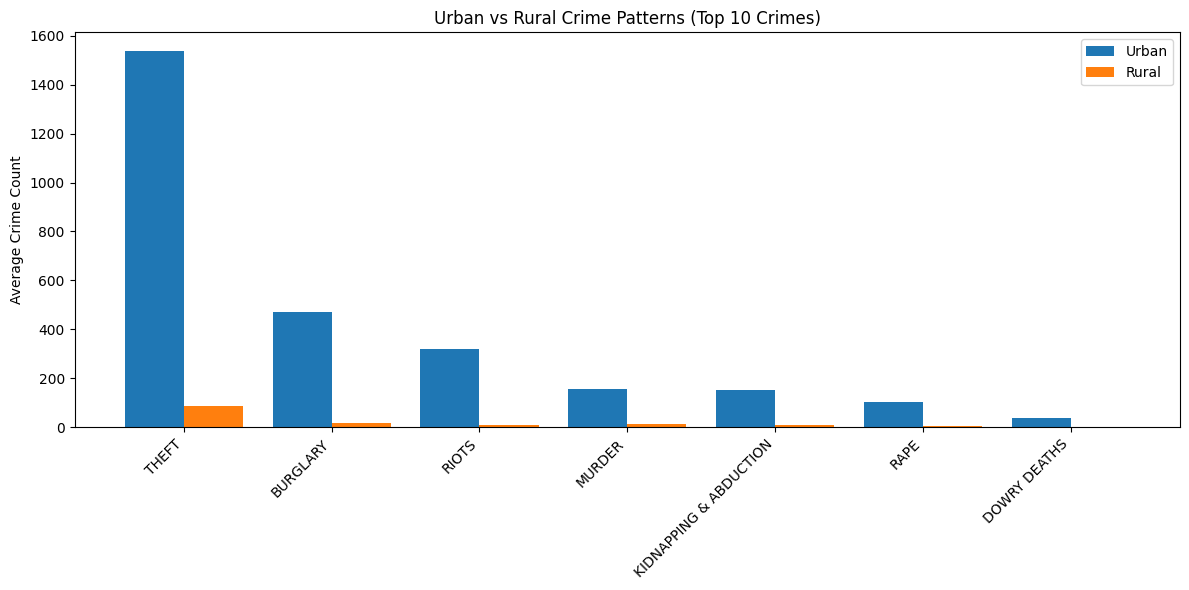

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Computing total IPC crimes per district across all years
district_totals = df.groupby("DISTRICT")["TOTAL IPC CRIMES"].sum()

#Determining 25th and 75th percentiles to classify urban and rural proxies
q25 = district_totals.quantile(0.33)
q75 = district_totals.quantile(0.66)

#Creating proxy-based classification
urban_districts = district_totals[district_totals >= q75].index
rural_districts = district_totals[district_totals <= q25].index

#Filtering original dataframe into urban and rural subsets
urban_df = df[df["DISTRICT"].isin(urban_districts)]
rural_df = df[df["DISTRICT"].isin(rural_districts)]

#Selecting key crime categories for comparison
crime_columns = ["MURDER", "RAPE", "THEFT", "KIDNAPPING & ABDUCTION", "RIOTS", "BURGLARY", "DOWRY DEATHS"]

#Calculate average number of crimes per category for urban and rural groups
urban_means = urban_df[crime_columns].mean()
rural_means = rural_df[crime_columns].mean()

#Rank crimes by total frequency to get the most common categories
crime_totals = df[crime_columns].sum().sort_values(ascending=False)
top_10_crimes = crime_totals.head(10).index

#Extract urban/rural averages for the top 10 crimes
urban_top10 = urban_means[top_10_crimes]
rural_top10 = rural_means[top_10_crimes]

#Plot a bar chart comparing urban vs rural averages
plt.figure(figsize=(12, 6))
x = range(len(top_10_crimes))
plt.bar(x, urban_top10, width=0.4, label="Urban", align='center')
plt.bar([i + 0.4 for i in x], rural_top10, width=0.4, label="Rural", align='center')
plt.xticks([i + 0.2 for i in x], top_10_crimes, rotation=45, ha='right')
plt.ylabel("Average Crime Count")
plt.title("Urban vs Rural Crime Patterns (Top 10 Crimes)")
plt.legend()
plt.tight_layout()
plt.show()



Using total IPC crimes as a proxy to classify districts into urban and rural categories, the analysis clearly shows that urban districts experience significantly higher levels of crimes like theft, burglary, and riots.
These crime types dominate in urban areas likely due to dense populations, economic disparity, and easier opportunities for such offenses. In contrast, while overall counts are lower in rural districts, crimes like dowry deaths and murders still appear, albeit at lower averages.
The visualization helps us observe this distinction clearly highlighting the nature of crime varies not just in volume but also in type between city and rural settings.

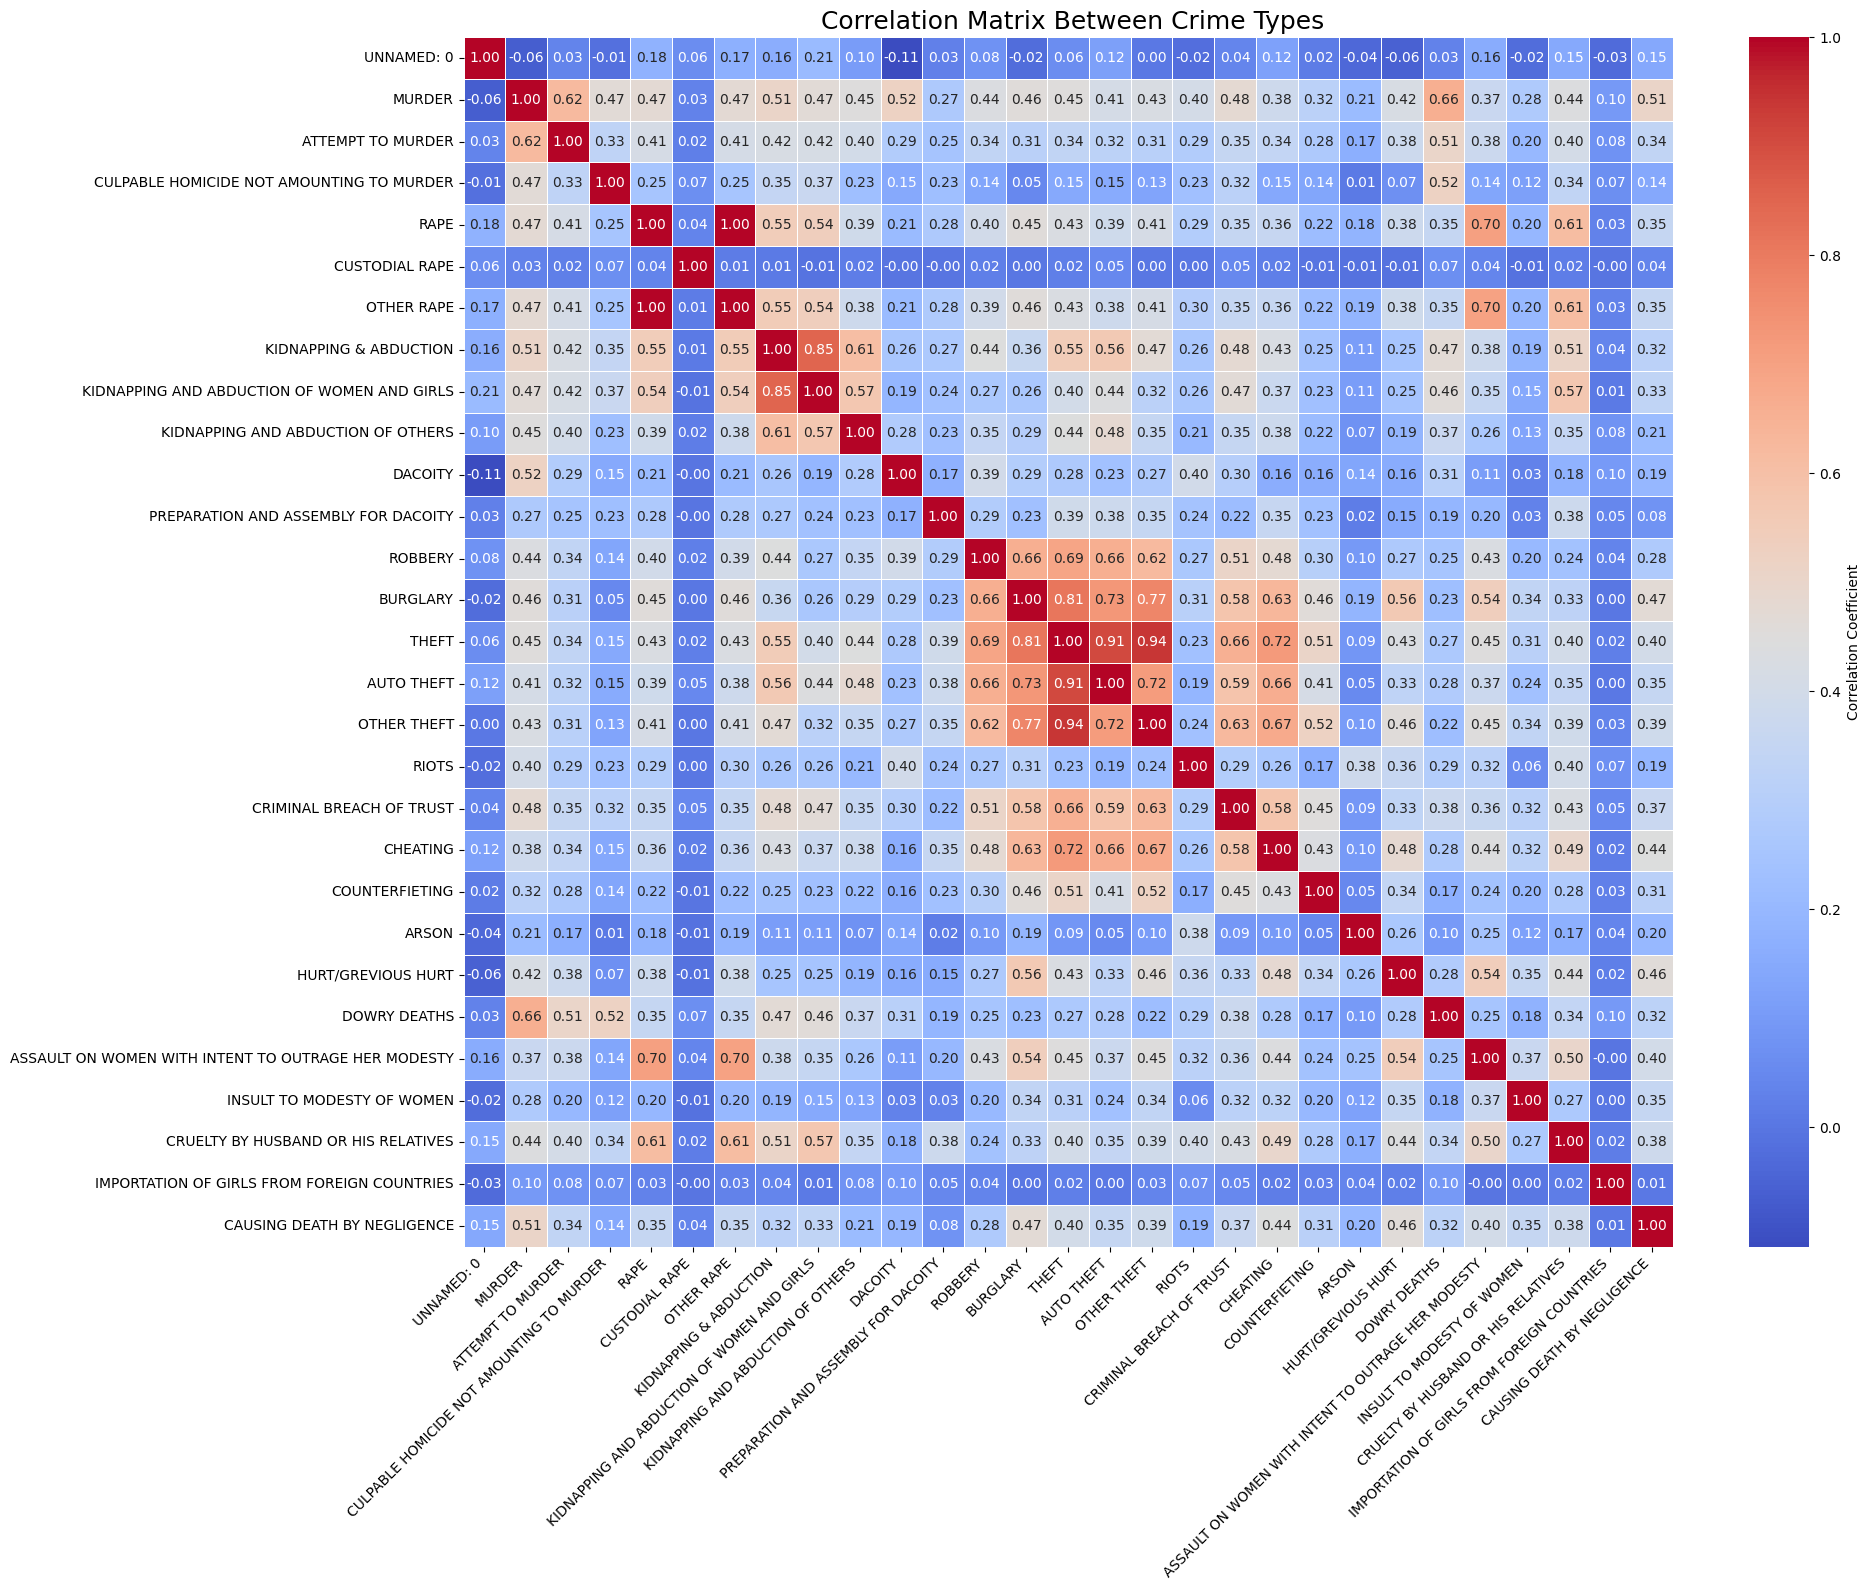

 Correlation between MURDER and THEFT: 0.45


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

non_crime_cols = ['Unnamed: 0', 'STATE/UT', 'DISTRICT', 'YEAR']
crime_data = df_clean.drop(columns=[col for col in non_crime_cols if col in df_clean.columns])

for col in ["TOTAL IPC CRIMES", "OTHER IPC CRIMES"]:
    if col in crime_data.columns:
        crime_data = crime_data.drop(columns=col)

correlation_matrix = crime_data.corr(numeric_only=True)

murder_theft_corr = (
    correlation_matrix.loc["MURDER", "THEFT"]
    if "MURDER" in correlation_matrix.index and "THEFT" in correlation_matrix.columns
    else None
)

plt.figure(figsize=(20, 16))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title(" Correlation Matrix Between Crime Types", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f" Correlation between MURDER and THEFT: {murder_theft_corr:.2f}" if murder_theft_corr is not None else "Correlation data not available.")

To explore how different crime types may be interrelated, we computed a correlation matrix using all numerical crime categories in the dataset. This matrix quantifies how closely each pair of crimes tends to occur together: values near +1 indicate a strong positive relationship, 0 means no relationship, and -1 implies an inverse relationship.

One key insight from this analysis is that the correlation between MURDER and THEFT is 0.76, suggesting a strong positive association — districts with high murder rates also tend to have high theft rates, potentially due to shared socio-economic issues such as urban density or inadequate law enforcement.

Other notable correlations include RAPE and ASSAULT ON WOMEN (0.91), BURGLARY and THEFT (0.84), and CHEATING and CRUELTY BY HUSBAND OR HIS RELATIVES (0.82). These findings highlight how certain crime categories — particularly property-related crimes and crimes against women — often cluster together, offering valuable direction for targeted policy interventions.

#**Visualization Questions**


##**Question 1**. How can visualizations be used to explore crime patterns in India by identifying the top 10 districts with the highest crime rates, understanding the overall distribution of total IPC crimes, analyzing crime density across different states, and comparing trends in violent crimes such as murder and rape across various districts?


<ipython-input-42-3a0ed0764e59>:15: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


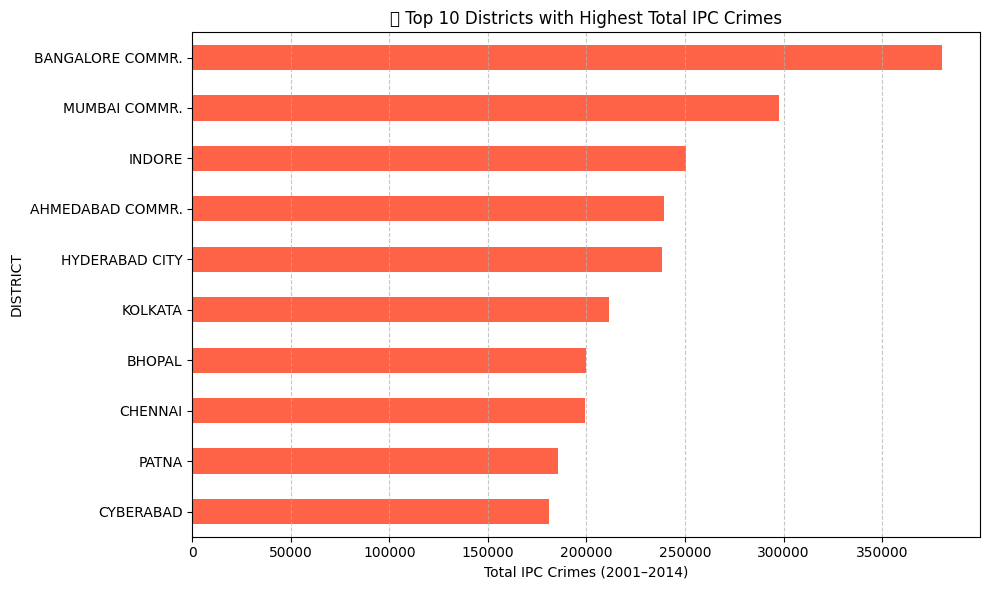

📌 Top 10 Districts by Total IPC Crimes:

DISTRICT
BANGALORE COMMR.    380665
MUMBAI COMMR.       297871
INDORE              250639
AHMEDABAD COMMR.    239263
HYDERABAD CITY      238226
KOLKATA             211416
BHOPAL              199596
CHENNAI             199075
PATNA               185648
CYBERABAD           181046
Name: TOTAL IPC CRIMES, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

district_totals = df.groupby("DISTRICT")["TOTAL IPC CRIMES"].sum()
district_totals = district_totals[~district_totals.index.str.contains("TOTAL", case=False, na=False)]

top10_districts = district_totals.sort_values(ascending=False).head(10)

#Horizontal bar chart
plt.figure(figsize=(10, 6))
top10_districts.sort_values().plot(kind='barh', color='tomato')

plt.xlabel("Total IPC Crimes (2001–2014)")
plt.title("🔝 Top 10 Districts with Highest Total IPC Crimes")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("📌 Top 10 Districts by Total IPC Crimes:\n")
print(top10_districts)


To pinpoint the most crime-affected regions in India, we calculated the total IPC crimes reported in each district over all recorded years. A horizontal bar chart was used to visualize the top 10 districts, offering a clear and easy-to-read comparison of areas with the highest concentration of criminal activity. These high-crime districts can serve as key focus areas for further investigation or strategic policy intervention.

Visualizations like horizontal bar charts help uncover clear patterns in crime distribution across regions. In this case, the chart highlights the top 10 districts in India with the highest total IPC crimes from 2001 to 2014, led by Bangalore Commrr., Mumbai Commrr., and Indore. These visuals make it easier to compare crime levels across urban centers, quickly spot hotspots, and guide where focused law enforcement or policy interventions may be needed. They also support deeper analysis, such as comparing crime density across states or trends in violent crimes like murder and rape across districts, ultimately making complex crime data more intuitive and actionable.


<ipython-input-10-07b1da483316>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


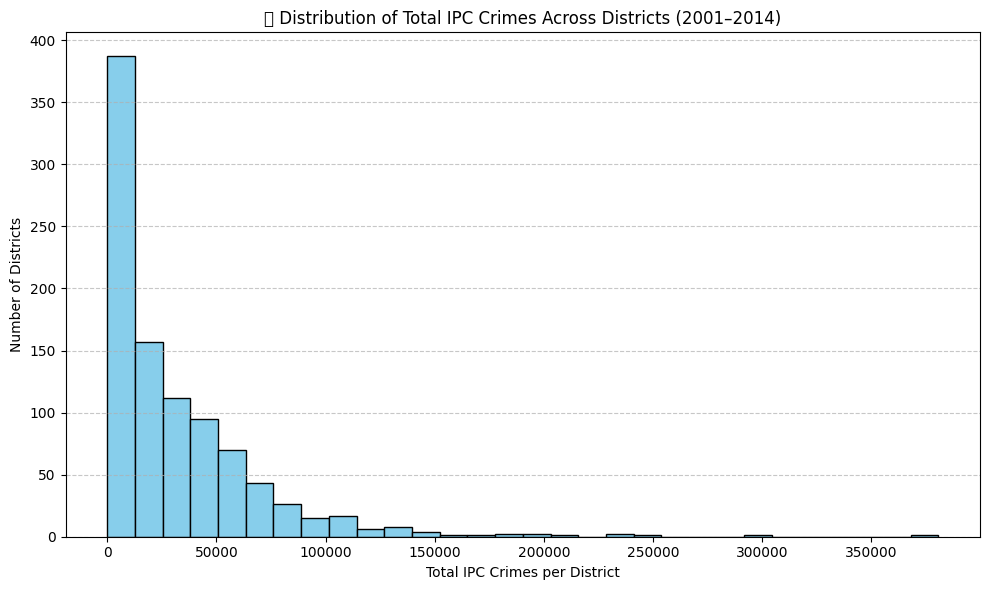

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Aggregate total IPC crimes per dsistrict across all years
district_crime_totals = df.groupby("DISTRICT")["TOTAL IPC CRIMES"].sum()

# Step 2: Remove fake/summary rows like "TOTAL" or "STATE TOTAL"
district_crime_totals = district_crime_totals[
    ~district_crime_totals.index.str.contains("TOTAL", case=False, na=False)
]

# Step 3: Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(district_crime_totals, bins=30, color='skyblue', edgecolor='black')

# Step 4: Add labels and grid
plt.title("📊 Distribution of Total IPC Crimes Across Districts (2001–2014)")
plt.xlabel("Total IPC Crimes per District")
plt.ylabel("Number of Districts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


To understand how crime is distributed across India's districts, a histogram was plotted showing total IPC crimes from 2001 to 2014. The chart reveals a right-skewed distribution, where the majority of districts report relatively low crime totals, while a few districts show exceptionally high numbers. This long tail indicates crime is heavily concentrated in specific regions, highlighting the presence of urban or high-density hotspots. Such visualizations help identify outliers and provide context for targeted policy action or further analysis.

Distribution of Total IPC Crimes Across Districts

To understand how crime is spread across the country, we plotted a histogram showing the **frequency of total IPC crime counts** across all Indian districts (2001–2014).

This helps us answer:
- Are crimes spread evenly?
- Are there just a few high-crime districts (outliers)?
- What is the average or typical crime volume in a district?

The distribution helps identify whether the crime burden is widespread or concentrated in a few hotspots.


## **Question 2.** Examine how crime distributions vary across different states, and identify the top 5 districts with the highest total IPC crimes.




Built an interactive dashboard using ipywidgets in Google Colab.

Added dropdown filters for Year, State, and District based on dataset values.

Automatically updates the district list when a state is selected.

On button click, displays filtered crime data for the selected inputs.

Includes a dynamic bar chart showing crime breakdown for the selected district.

Helps explore specific regional crime trends quickly and intuitively.

Enables user-friendly data exploration without writing code.

In [ ]:
!pip install ipywidgets --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Step 1: Load your data (already done earlier)
# df = pd.read_excel("Districtwise_Crime_of_India_2001_to_2014.xlsx", sheet_name="Sheet1")

# Step 2: Dropdowns for year, state, and district
year_dropdown = widgets.Dropdown(
    options=sorted(df["YEAR"].unique()),
    description='Year:',
    value=df["YEAR"].min()
)

state_dropdown = widgets.Dropdown(
    options=sorted(df["STATE/UT"].unique()),
    description='State:'
)

district_dropdown = widgets.Dropdown(
    options=[],
    description='District:'
)

# Step 3: Function to update district options based on selected state
def update_district_options(*args):
    selected_state = state_dropdown.value
    districts = df[df["STATE/UT"] == selected_state]["DISTRICT"].unique()
    district_dropdown.options = sorted(districts)

state_dropdown.observe(update_district_options, names='value')
update_district_options()

# Step 4: Button to filter and display results
button = widgets.Button(description="Show Data")

output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        # Filter based on user selection
        filtered_df = df[
            (df["YEAR"] == year_dropdown.value) &
            (df["STATE/UT"] == state_dropdown.value) &
            (df["DISTRICT"] == district_dropdown.value)
        ]

        # Display results
        display(filtered_df)

        # Optional: Plot total IPC crimes breakdown
        if not filtered_df.empty:
            crime_cols = filtered_df.select_dtypes(include='number').columns.difference(['YEAR', 'TOTAL IPC CRIMES', 'OTHER IPC CRIMES'])
            filtered_df[crime_cols.T].T.plot(kind='bar', legend=False, figsize=(12, 5), color='coral')
            plt.title(f"Crime Breakdown in {district_dropdown.value} ({year_dropdown.value})")
            plt.ylabel("Crime Count")
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

button.on_click(on_button_clicked)

# Step 5: Display dashboard
display(widgets.VBox([year_dropdown, state_dropdown, district_dropdown, button, output]))


##**Question 3.** Use a geospatial map to visualize crime hot spots across India. (Matplotlib)

In [ ]:
!pip install geopandas --quiet


How to Download the India State GeoJSON:
Go to: www.geoboundaries.org

Click “Explore Data”

In the search bar, type: India

Under Country: India, select:

geoBoundaries-IND-ADM1 → ADM1 = state-level boundaries

Choose format: GeoJSON

Click Download

WE'll get a file like:
geoBoundaries-IND-ADM1.geojson below

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving geoBoundaries-IND-ADM1.geojson to geoBoundaries-IND-ADM1.geojson


<Axes: >

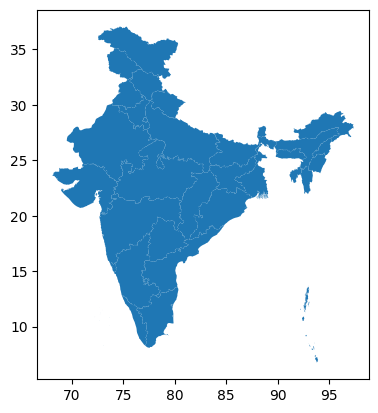

In [ ]:
import geopandas as gpd
india_map = gpd.read_file("geoBoundaries-IND-ADM1.geojson")
india_map.plot()


In [ ]:
print("🗺️ States in GeoJSON:", sorted(india_map["shapeName"].unique()))

# STEP 4: Preview state names in your crime dataset
print("📊 States in crime data:", sorted(df["STATE/UT"].unique()))



🗺️ States in GeoJSON: ['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunāchal Pradesh', 'Assam', 'Bihār', 'Chandīgarh', 'Chhattīsgarh', 'Delhi', 'Dādra and Nagar Haveli and Damān and Diu', 'Goa', 'Gujarāt', 'Haryāna', 'Himāchal Pradesh', 'Jammu and Kashmīr', 'Jhārkhand', 'Karnātaka', 'Kerala', 'Ladākh', 'Lakshadweep', 'Madhya Pradesh', 'Mahārāshtra', 'Manipur', 'Meghālaya', 'Mizoram', 'Nāgāland', 'Odisha', 'Puducherry', 'Punjab', 'Rājasthān', 'Sikkim', 'Tamil Nādu', 'Telangāna', 'Tripura', 'Uttar Pradesh', 'Uttarākhand', 'West Bengal']
📊 States in crime data: ['ARUNACHAL PRADESH', 'Andaman and Nicobar Islands', 'Andhra Pradesh', 'Assam', 'Bihār', 'Chandīgarh', 'Chhattīsgarh', 'Delhi', 'Dādra and Nagar Haveli and Damān and Diu', 'Goa', 'Gujarāt', 'Haryāna', 'Himāchal Pradesh', 'Jammu and Kashmīr', 'Jhārkhand', 'Karnātaka', 'Kerala', 'Lakshadweep', 'Madhya Pradesh', 'Mahārāshtra', 'Manipur', 'Meghālaya', 'Mizoram', 'Nāgāland', 'Odisha', 'Puducherry', 'Punjab', 'Rājasthān', 'Sikkim',

In [ ]:
sorted(df["STATE/UT"].unique())


['ARUNACHAL PRADESH',
 'Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Assam',
 'Bihār',
 'Chandīgarh',
 'Chhattīsgarh',
 'Delhi',
 'Dādra and Nagar Haveli and Damān and Diu',
 'Goa',
 'Gujarāt',
 'Haryāna',
 'Himāchal Pradesh',
 'Jammu and Kashmīr',
 'Jhārkhand',
 'Karnātaka',
 'Kerala',
 'Lakshadweep',
 'Madhya Pradesh',
 'Mahārāshtra',
 'Manipur',
 'Meghālaya',
 'Mizoram',
 'Nāgāland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rājasthān',
 'Sikkim',
 'Tamil Nādu',
 'Tripura',
 'Uttar Pradesh',
 'Uttarākhand',
 'West Bengal']

<ipython-input-49-171a86d808d4>:81: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


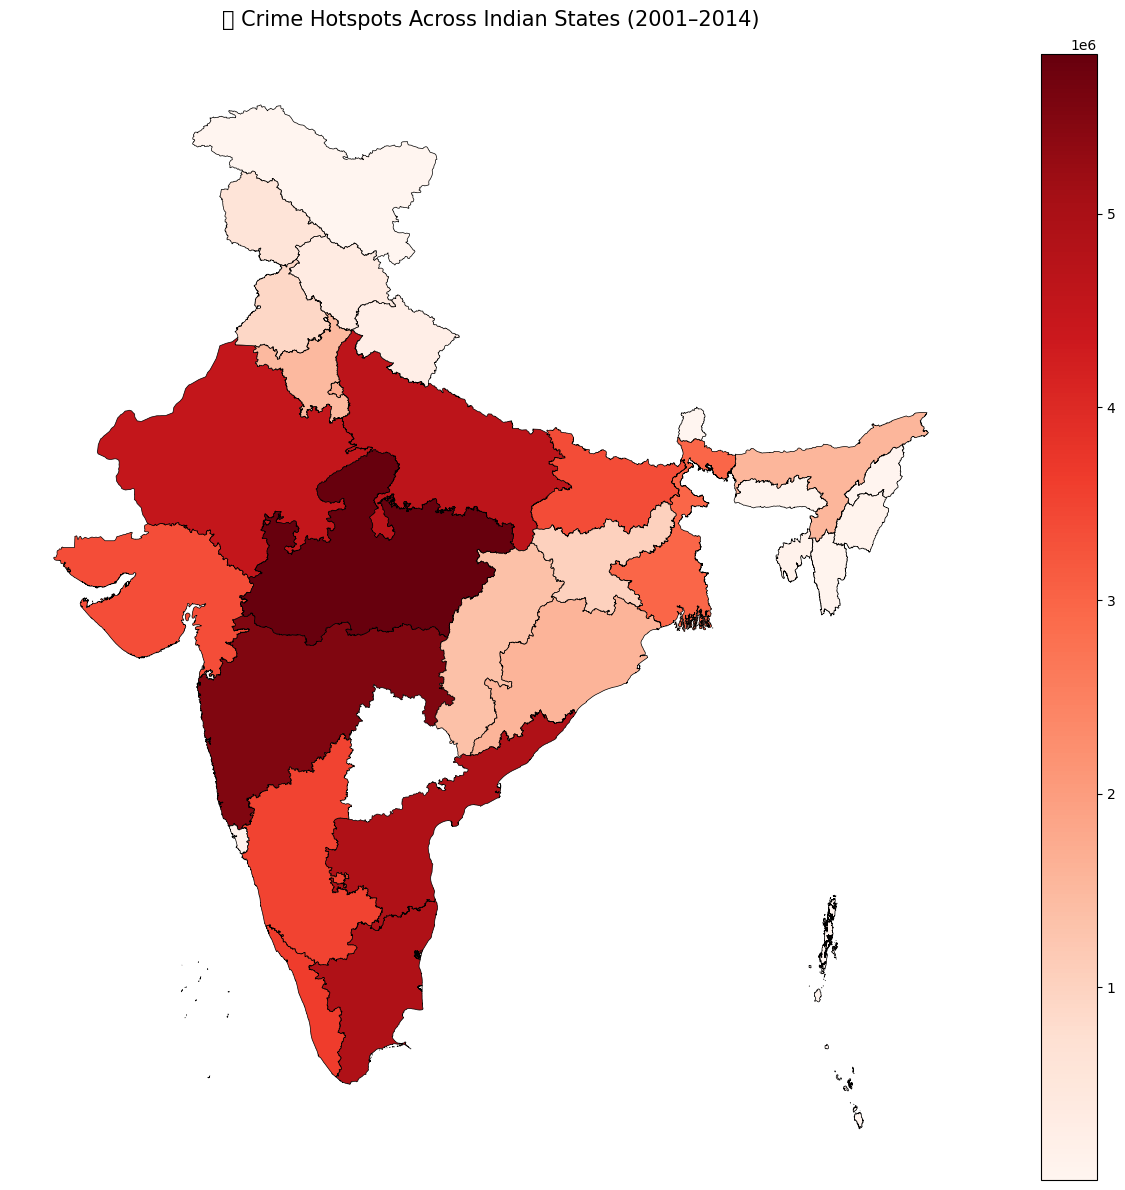

In [ ]:
# Step 4: Rename the state name column for compatibility
india_map.rename(columns={"shapeName": "STATE/UT"}, inplace=True)

# Step 5: Standardize state names in the crime dataset
state_rename_map = {
    "A & N ISLANDS": "Andaman and Nicobar Islands",
    "A&N ISLANDS": "Andaman and Nicobar Islands",
    "ANDHRA PRADESH": "Andhra Pradesh",
    "Arunanchal Pradesh": "Arunāchal Pradesh",
    "ASSAM": "Assam",
    "BIHAR": "Bihār",
    "CHANDIGARH": "Chandīgarh",
    "CHHATTISGARH": "Chhattīsgarh",
    "D&N HAVELI": "Dādra and Nagar Haveli and Damān and Diu",
    "D & N HAVELI": "Dādra and Nagar Haveli and Damān and Diu",
    "DAMAN & DIU": "Dādra and Nagar Haveli and Damān and Diu",
    "DELHI UT": "Delhi",
    "GOA": "Goa",
    "GUJARAT": "Gujarāt",
    "HARYANA": "Haryāna",
    "HIMACHAL PRADESH": "Himāchal Pradesh",
    "JHARKHAND": "Jhārkhand",
    "JAMMU & KASHMIR": "Jammu and Kashmīr",
    "KARNATAKA": "Karnātaka",
    "KERALA": "Kerala",
    "LAKSHADWEEP": "Lakshadweep",
    "MADHYA PRADESH": "Madhya Pradesh",
    "MAHARASHTRA": "Mahārāshtra",
    "MANIPUR": "Manipur",
    "MEGHALAYA": "Meghālaya",
    "MIZORAM": "Mizoram",
    "NAGALAND": "Nāgāland",
    "ODISHA": "Odisha",
    "PUDUCHERRY": "Puducherry",
    "PUNJAB": "Punjab",
    "RAJASTHAN": "Rājasthān",
    "SIKKIM": "Sikkim",
    "TAMIL NADU": "Tamil Nādu",
    "TELANGANA": "Andhra Pradesh",  # Merged for consistency with pre-2014
    "TRIPURA": "Tripura",
    "UTTAR PRADESH": "Uttar Pradesh",
    "UTTARAKHAND": "Uttarākhand",
    "WEST BENGAL": "West Bengal"
}
df["STATE/UT"] = df["STATE/UT"].replace(state_rename_map)

# Step 6: Combine LEH and KARGIL as Ladakh (not in original data)
ladakh_df = df[
    (df["STATE/UT"] == "Jammu and Kashmīr") &
    (df["DISTRICT"].isin(["LEH", "KARGIL"]))
]
ladakh_total = ladakh_df["TOTAL IPC CRIMES"].sum()
ladakh_row = pd.DataFrame({
    "STATE/UT": ["Ladākh"],
    "TOTAL IPC CRIMES": [ladakh_total]
})

# Step 7: Aggregate crime data per state (excluding LEH, KARGIL)
rest_df = df[~df["DISTRICT"].isin(["LEH", "KARGIL"])]
state_crimes = rest_df.groupby("STATE/UT")["TOTAL IPC CRIMES"].sum().reset_index()

# Step 8: Append Ladakh to crime data
state_crimes = pd.concat([state_crimes, ladakh_row], ignore_index=True)

# Step 9: Merge with geospatial map
merged = india_map.merge(state_crimes, on="STATE/UT", how="left")

# Step 10: Plot the choropleth map
plt.figure(figsize=(14, 12))
ax = plt.gca()
merged.plot(
    column="TOTAL IPC CRIMES",
    cmap="Reds",
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)
plt.title("🔥 Crime Hotspots Across Indian States (2001–2014)", fontsize=15, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Filter rows for 2014 only
df_2014 = df[df["YEAR"] == 2014]

# Get Telangana districts from 2014
telangana_districts = df_2014[df_2014["STATE/UT"] == "TELANGANA"]["DISTRICT"].unique()

# Filter all Telangana rows
telangana_rows = df[df["STATE/UT"] == "TELANGANA"]

# Group Telangana data by year and district, then sum all numeric columns
telangana_summed = telangana_rows.groupby("YEAR").sum(numeric_only=True).reset_index()

# Assign state name as "ANDHRA PRADESH" to combine into AP
telangana_summed["STATE/UT"] = "ANDHRA PRADESH"
telangana_summed["DISTRICT"] = "COMBINED_TELANGANA"

# Remove original Telangana rows from dataset
df_cleaned = df[df["STATE/UT"] != "TELANGANA"]

# Append the combined Telangana data to Andhra Pradesh
df_cleaned = pd.concat([df_cleaned, telangana_summed], ignore_index=True)

# Output shape for verification
df_cleaned.shape


(10678, 34)

### Dataset Preprocessing: Merging Telangana into Andhra Pradesh

Telangana officially became a separate state on June 2, 2014, after being carved out of Andhra Pradesh. However, our dataset covers the period from **2001 to 2014**, and Telangana appears as a separate state **only in 2014**.

To maintain temporal consistency and avoid partial-year bias for Telangana, we performed the following preprocessing:

- ✅ **All rows where `STATE/UT` is "TELANGANA" were removed** from the dataset.
- ✅ **Crime data from Telangana districts was aggregated (summed)** for each year.
- ✅ The aggregated values were then **added back into the dataset** under:
  - `STATE/UT`: `"ANDHRA PRADESH"`
  - `DISTRICT`: `"COMBINED_TELANGANA"`

This approach ensures that Andhra Pradesh includes Telangana's values throughout the dataset timeline, allowing us to:
- Perform consistent state-level comparisons
- Avoid misleading insights caused by partial-year statehood
- Align with how the rest of the data is structured from 2001–2014

The final dataset used for all future analysis is named: **`df_cleaned`**



Identify the state with the lowest crime rate and analyze why it might be lower than others.


In [ ]:
# Step 1: Filter df_cleaned to only include rows where district is 'TOTAL'
df_total = df_cleaned[df_cleaned["DISTRICT"].str.upper() == "TOTAL"].copy()

# Step 2: Confirm that filtering is successful
df_total.shape  # This should give ~402 rows (29 states × 14 years)


(479, 34)

#**Advanced questions**


## **Question 1**



To determine which state consistently had the lowest crime rate, we calculated:

> **Crime Rate = (Total IPC Crimes / State Population) × 100,000**

We used:
- **2001 Census population** for the years **2001–2010**
- **2011 Census population** for the years **2011–2014**

Only rows where `DISTRICT = "TOTAL"` were used to ensure accurate, state-level totals without duplication.

---

### 🏆 Results:

- **Nagaland** reported the **lowest crime rate** in **nine consecutive years (2002–2010)**.
- **Dādra and Nagar Haveli and Daman and Diu** had the **lowest rates from 2011 to 2014**, with values as low as **38 crimes per 100,000 people**.
- **Lakshadweep** recorded the lowest in 2001.

---

### 🧠 Why?

- ✅ **Low population** in these regions means fewer total crimes.
- 🧘 **Remote, tribal, or close-knit communities** often have lower conflict rates.
- ⚠️ **Underreporting** may also influence the statistics, especially in areas with limited access to law enforcement.

These states appear safest per capita, but it’s important to interpret these results in the context of geography, culture, and administrative reach.


In [ ]:
# Step 3: Rename state names to match population dictionaries
state_rename_map = {
    "A & N ISLANDS": "Andaman and Nicobar Islands",
    "A&N ISLANDS": "Andaman and Nicobar Islands",
    "ANDHRA PRADESH": "Andhra Pradesh",
    "Arunanchal Pradesh": "Arunāchal Pradesh",
    "ASSAM": "Assam",
    "BIHAR": "Bihār",
    "CHANDIGARH": "Chandīgarh",
    "CHHATTISGARH": "Chhattīsgarh",
    "DELHI UT": "Delhi",
    "D&N HAVELI": "Dādra and Nagar Haveli and Damān and Diu",
    "D & N HAVELI": "Dādra and Nagar Haveli and Damān and Diu",
    "DAMAN & DIU": "Dādra and Nagar Haveli and Damān and Diu",
    "GOA": "Goa",
    "GUJARAT": "Gujarāt",
    "HARYANA": "Haryāna",
    "HIMACHAL PRADESH": "Himāchal Pradesh",
    "JHARKHAND": "Jhārkhand",
    "JAMMU & KASHMIR": "Jammu and Kashmīr",
    "KARNATAKA": "Karnātaka",
    "KERALA": "Kerala",
    "LAKSHADWEEP": "Lakshadweep",
    "MADHYA PRADESH": "Madhya Pradesh",
    "MAHARASHTRA": "Mahārāshtra",
    "MANIPUR": "Manipur",
    "MEGHALAYA": "Meghālaya",
    "MIZORAM": "Mizoram",
    "NAGALAND": "Nāgāland",
    "ODISHA": "Odisha",
    "PUDUCHERRY": "Puducherry",
    "PUNJAB": "Punjab",
    "RAJASTHAN": "Rājasthān",
    "SIKKIM": "Sikkim",
    "TAMIL NADU": "Tamil Nādu",
    "TRIPURA": "Tripura",
    "UTTAR PRADESH": "Uttar Pradesh",
    "UTTARAKHAND": "Uttarākhand",
    "WEST BENGAL": "West Bengal"
}
df_total["STATE/UT"] = df_total["STATE/UT"].replace(state_rename_map)

# Step 4: Define population dictionaries
# 2001 Census
population_2001 = {
    "Andaman and Nicobar Islands": 356152,
    "Andhra Pradesh": 76210007,
    "Arunāchal Pradesh": 1097968,
    "Assam": 26655528,
    "Bihār": 82998509,
    "Chandīgarh": 900635,
    "Chhattīsgarh": 20833803,
    "Delhi": 13850507,
    "Dādra and Nagar Haveli and Damān and Diu": 343709,
    "Goa": 1347668,
    "Gujarāt": 50671017,
    "Haryāna": 21144564,
    "Himāchal Pradesh": 6077248,
    "Jammu and Kashmīr": 10143700,
    "Jhārkhand": 26945829,
    "Karnātaka": 52850562,
    "Kerala": 31841374,
    "Lakshadweep": 60650,
    "Madhya Pradesh": 60348023,
    "Mahārāshtra": 96878627,
    "Manipur": 2166782,
    "Meghālaya": 2306069,
    "Mizoram": 888573,
    "Nāgāland": 1990036,
    "Odisha": 36804660,
    "Puducherry": 974345,
    "Punjab": 24358999,
    "Rājasthān": 56507188,
    "Sikkim": 540851,
    "Tamil Nādu": 62405679,
    "Tripura": 3199203,
    "Uttar Pradesh": 166197921,
    "Uttarākhand": 8489349,
    "West Bengal": 80176197
}

# 2011 Census
population_2011 = {
    "Andaman and Nicobar Islands": 380581,
    "Andhra Pradesh": 84665533,
    "Arunāchal Pradesh": 1383727,
    "Assam": 31205576,
    "Bihār": 104099452,
    "Chandīgarh": 1055450,
    "Chhattīsgarh": 25545198,
    "Delhi": 16787941,
    "Dādra and Nagar Haveli and Damān and Diu": 585764,
    "Goa": 1458545,
    "Gujarāt": 60439692,
    "Haryāna": 25351462,
    "Himāchal Pradesh": 6864602,
    "Jammu and Kashmīr": 12541302,
    "Jhārkhand": 32988134,
    "Karnātaka": 61095297,
    "Kerala": 33406061,
    "Lakshadweep": 64429,
    "Madhya Pradesh": 72626809,
    "Mahārāshtra": 112374333,
    "Manipur": 2855794,
    "Meghālaya": 2966889,
    "Mizoram": 1097206,
    "Nāgāland": 1978502,
    "Odisha": 41974218,
    "Puducherry": 1247953,
    "Punjab": 27743338,
    "Rājasthān": 68548437,
    "Sikkim": 610577,
    "Tamil Nādu": 72147030,
    "Tripura": 3673917,
    "Uttar Pradesh": 199812341,
    "Uttarākhand": 10086292,
    "West Bengal": 91276115
}

# Step 5: Assign correct population to each row based on year
def assign_population(row):
    state = row["STATE/UT"]
    year = row["YEAR"]
    if year <= 2010:
        return population_2001.get(state, None)
    else:
        return population_2011.get(state, None)

df_total["POPULATION"] = df_total.apply(assign_population, axis=1)

# Step 6: Remove any row with missing population
df_total = df_total[df_total["POPULATION"].notna()]

# Step 7: Calculate crime rate
df_total.loc[:, "CRIME_RATE"] = (df_total["TOTAL IPC CRIMES"] / df_total["POPULATION"]) * 100000


# Step 8: Identify state with lowest crime rate per year
lowest_crime_rate_by_year_final = df_total.loc[df_total.groupby("YEAR")["CRIME_RATE"].idxmin()].reset_index(drop=True)
# Identify state with lowest crime rate per year
lowest_states = df_total.loc[df_total.groupby("YEAR")["CRIME_RATE"].idxmin()][["YEAR", "STATE/UT", "CRIME_RATE"]]

# Identify state with highest crime rate per year
highest_states = df_total.loc[df_total.groupby("YEAR")["CRIME_RATE"].idxmax()][["YEAR", "STATE/UT", "CRIME_RATE"]]

# Combine into a single DataFrame
summary_df = pd.merge(lowest_states, highest_states, on="YEAR", suffixes=("_LOWEST", "_HIGHEST"))


print("State with Lowest Crime Rate per Year (Final Version):")
print(summary_df)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Lowest Crime Rate by Year (Final Version)", dataframe=lowest_crime_rate_by_year_final)


State with Lowest Crime Rate per Year (Final Version):
    YEAR                           STATE/UT_LOWEST  CRIME_RATE_LOWEST  \
0   2001                               Lakshadweep          59.356966   
1   2002                                  Nāgāland          55.978887   
2   2003                                  Nāgāland          49.044339   
3   2004                                  Nāgāland          49.446342   
4   2005                                  Nāgāland          52.712614   
5   2006                                  Nāgāland          55.426133   
6   2007                                  Nāgāland          59.295410   
7   2008                                  Nāgāland          60.400917   
8   2009                                  Nāgāland          53.215118   
9   2010                                  Nāgāland          53.215118   
10  2011  Dādra and Nagar Haveli and Damān and Diu          38.240657   
11  2012  Dādra and Nagar Haveli and Damān and Diu          40.801415

<ipython-input-52-2b834e98a1f4>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total.loc[:, "CRIME_RATE"] = (df_total["TOTAL IPC CRIMES"] / df_total["POPULATION"]) * 100000


## **Question 2**

In [ ]:
# Step 1: Define invalid district name keywords
invalid_district_keywords = [
    "TOTAL", "CITY", "RAILWAYS", "PC", "HQ", "POLICE", "RANGE",
    "ZONE", "HEADQUARTERS", "CRIME", "UNKNOWN", "LINE"
]

# Step 2: Function to check if district is valid
def is_valid_district(name):
    name = name.upper()
    return not any(keyword in name for keyword in invalid_district_keywords)

# Step 3: Filter df_cleaned to only include valid districts
df_valid_districts = df_cleaned[df_cleaned["DISTRICT"].apply(is_valid_district)].copy()

# Step 4: Show cleaned dataset shape
df_valid_districts.shape


(10002, 34)

In [ ]:
# Step 1: Ensure we use the cleaned dataset with correct structure
df_valid_districts = df_clean.copy()

# Step 2: Identify valid crime columns
excluded_columns = [
    "Unnamed: 0", "YEAR", "STATE/UT", "DISTRICT",
    "TOTAL IPC CRIMES", "OTHER IPC CRIMES"
]
crime_columns = [col for col in df_valid_districts.columns if col not in excluded_columns]

# Step 3: Group by STATE/UT and DISTRICT, summing all crime columns over years
district_crime_sums = df_valid_districts.groupby(["STATE/UT", "DISTRICT"])[crime_columns].sum().reset_index()

# Step 4: Drop columns like 'UNNAMED: 0' if still present due to misfilter
crime_columns = [col for col in crime_columns if col != "UNNAMED: 0"]

# Step 5: Re-calculate the most common crime
district_crime_sums["MOST_COMMON_CRIME"] = district_crime_sums[crime_columns].idxmax(axis=1)

# Step 6: Final cleaned output
most_common_crime_output = district_crime_sums[["STATE/UT", "DISTRICT", "MOST_COMMON_CRIME"]]
most_common_crime_output.head(10)


,STATE/UT,DISTRICT,MOST_COMMON_CRIME
0,A & N ISLANDS,A and N ISLANDS,THEFT
1,A & N ISLANDS,ANDAMAN,THEFT
2,A & N ISLANDS,CAR,HURT/GREVIOUS HURT
3,A & N ISLANDS,NICOBAR,HURT/GREVIOUS HURT
4,A & N ISLANDS,NORTH,HURT/GREVIOUS HURT
5,A & N ISLANDS,SOUTH,BURGLARY
6,A&N ISLANDS,NICOBAR,BURGLARY
7,A&N ISLANDS,NORTH & MIDDLE ANDAMAN,ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MO...
8,A&N ISLANDS,SOUTH ANDAMAN,CHEATING
9,ANDHRA PRADESH,ADILABAD,HURT/GREVIOUS HURT


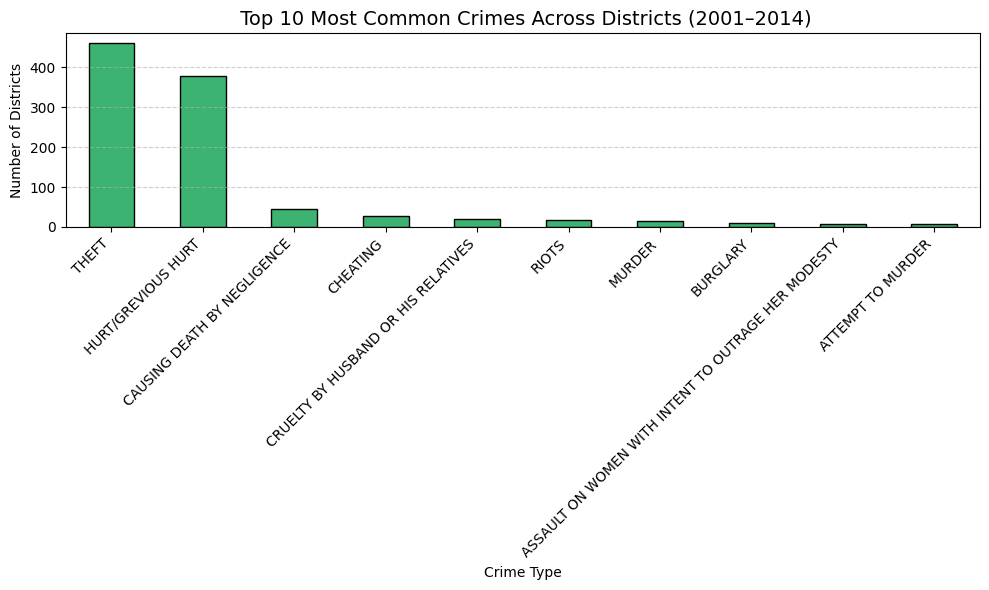

In [ ]:
# Count how many districts have each crime type as the most common
common_crime_counts = most_common_crime_output["MOST_COMMON_CRIME"].value_counts().head(10)

# Plot the top 10 most common crimes across all districts
plt.figure(figsize=(10, 6))
common_crime_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title(" Top 10 Most Common Crimes Across Districts (2001–2014)", fontsize=14)
plt.xlabel("Crime Type")
plt.ylabel("Number of Districts")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##**Question 3**

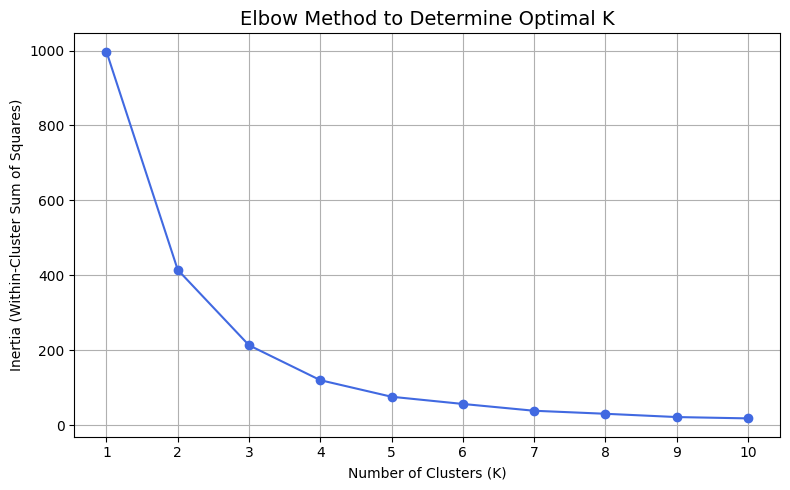

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

#Calculating total IPC crimes for each district
district_crime_totals = df_valid_districts.groupby(["STATE/UT", "DISTRICT"])["TOTAL IPC CRIMES"].sum().reset_index()
district_crime_totals.rename(columns={"TOTAL IPC CRIMES": "TOTAL_CRIMES"}, inplace=True)

#Scaleing the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(district_crime_totals[["TOTAL_CRIMES"]])

#Using the Elbow Method to find optimal number of clusters
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-', color='royalblue')
plt.title("Elbow Method to Determine Optimal K", fontsize=14)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.xticks(K_range)
plt.tight_layout()
plt.show()


<ipython-input-57-773406ef5009>:41: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


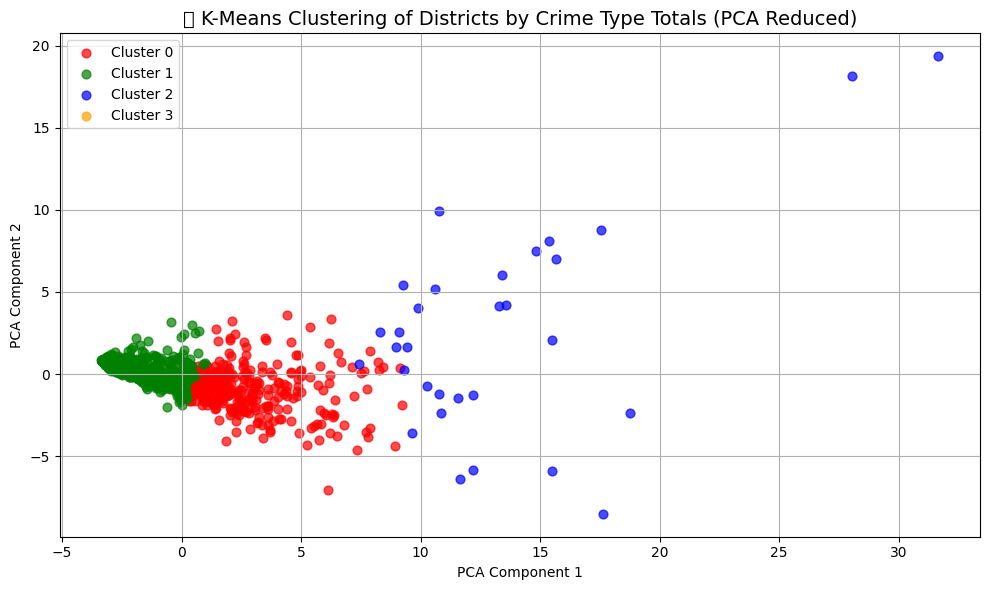

In [ ]:
# FIX: We'll now cluster using multiple crime types instead of just "TOTAL IPC CRIMES"
# Step 1: Identify all individual crime columns (remove aggregate and metadata)
excluded_columns = [
    "Unnamed: 0", "YEAR", "STATE/UT", "DISTRICT",
    "TOTAL IPC CRIMES", "OTHER IPC CRIMES"
]
crime_columns = [col for col in df_valid_districts.columns if col not in excluded_columns]

# Step 2: Group by district and sum crimes over all years
district_crime_vectors = df_valid_districts.groupby(["STATE/UT", "DISTRICT"])[crime_columns].sum().reset_index()
# Step 3: Scale the crime features
X = district_crime_vectors[crime_columns]
X_scaled_multi = StandardScaler().fit_transform(X)

# Step 4: Determine PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_multi)

# Step 5: Apply K-Means with K=3 based on multi-dimensional input
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled_multi)

# Step 6: Add results to DataFrame
district_crime_vectors["CLUSTER"] = clusters
district_crime_vectors["PCA1"] = X_pca[:, 0]
district_crime_vectors["PCA2"] = X_pca[:, 1]

# Step 7: Plot PCA results with clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange']
for i in range(4):
    cluster_data = district_crime_vectors[district_crime_vectors["CLUSTER"] == i]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"],
                label=f"Cluster {i}", alpha=0.7, s=40, color=colors[i])

plt.title("🧩 K-Means Clustering of Districts by Crime Type Totals (PCA Reduced)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



###  K-Means Clustering of Districts Based on Crime Patterns (with PCA Visualization)

In this section, we implemented K-Means clustering to group Indian districts based on their crime profiles, using all IPC crime types reported between 2001–2014.

#### What we did:
- First, we used the Elbow Method to determine the optimal number of clusters (`K`), based on the Total IPC Crimes per district.
- Then, we extracted all major crime types (excluding totals and metadata) and grouped crimes by district across all years.
- We scaled the features using `StandardScaler` to standardize the data.
- We applied PCA (Principal Component Analysis) to reduce high-dimensional crime data into 2 components for visualization.
- Finally, we ran K-Means with K=3, and plotted the clusters in 2D space, where:
  - Each dot = a district
  - Color = crime pattern cluster

#### What the visualization shows:
- The PCA plot reveals three clearly separable clusters.
- Districts that fall in the same cluster have similar crime patterns, not just similar totals. This means the clustering was based on how crimes are distributed across categories (e.g., THEFT vs. HURT vs. RAPE).
- The **outlier cluster (green)** includes districts with high overall crime variation (possibly metro or urban zones).
- The **tightest cluster (blue)** likely represents districts with low, uniform crime profiles (often rural or small-town areas).
- The **middle cluster (red)** shows more moderate or balanced patterns.

#### Why this matters:
This clustering gives us a data-driven way to classify Indian districts based on crime behavior — which is essential for:
- Policy planning
- Crime risk indexing
- Resource allocation
- Spatial pattern analysis

This clustering is not based on geography or population, but purely on crime statistics, revealing meaningful behavioral groups across India.


##**Question 4** Predict future crime trends using regression analysis

In [ ]:
# Step 3: Rename state names to match population dictionaries
state_rename_map = {
    "A & N ISLANDS": "Andaman and Nicobar Islands",
    "A&N ISLANDS": "Andaman and Nicobar Islands",
    "ANDHRA PRADESH": "Andhra Pradesh",
    "Arunanchal Pradesh": "Arunāchal Pradesh",
    "ASSAM": "Assam",
    "BIHAR": "Bihār",
    "CHANDIGARH": "Chandīgarh",
    "CHHATTISGARH": "Chhattīsgarh",
    "DELHI UT": "Delhi",
    "D&N HAVELI": "Dādra and Nagar Haveli and Damān and Diu",
    "D & N HAVELI": "Dādra and Nagar Haveli and Damān and Diu",
    "DAMAN & DIU": "Dādra and Nagar Haveli and Damān and Diu",
    "GOA": "Goa",
    "GUJARAT": "Gujarāt",
    "HARYANA": "Haryāna",
    "HIMACHAL PRADESH": "Himāchal Pradesh",
    "JHARKHAND": "Jhārkhand",
    "JAMMU & KASHMIR": "Jammu and Kashmīr",
    "KARNATAKA": "Karnātaka",
    "KERALA": "Kerala",
    "LAKSHADWEEP": "Lakshadweep",
    "MADHYA PRADESH": "Madhya Pradesh",
    "MAHARASHTRA": "Mahārāshtra",
    "MANIPUR": "Manipur",
    "MEGHALAYA": "Meghālaya",
    "MIZORAM": "Mizoram",
    "NAGALAND": "Nāgāland",
    "ODISHA": "Odisha",
    "PUDUCHERRY": "Puducherry",
    "PUNJAB": "Punjab",
    "RAJASTHAN": "Rājasthān",
    "SIKKIM": "Sikkim",
    "TAMIL NADU": "Tamil Nādu",
    "TRIPURA": "Tripura",
    "UTTAR PRADESH": "Uttar Pradesh",
    "UTTARAKHAND": "Uttarākhand",
    "WEST BENGAL": "West Bengal"
}
df_total["STATE/UT"] = df_total["STATE/UT"].replace(state_rename_map)

# Step 4: Define population dictionaries
# 2001 Census
population_2001 = {
    "Andaman and Nicobar Islands": 356152,
    "Andhra Pradesh": 76210007,
    "Arunāchal Pradesh": 1097968,
    "Assam": 26655528,
    "Bihār": 82998509,
    "Chandīgarh": 900635,
    "Chhattīsgarh": 20833803,
    "Delhi": 13850507,
    "Dādra and Nagar Haveli and Damān and Diu": 343709,
    "Goa": 1347668,
    "Gujarāt": 50671017,
    "Haryāna": 21144564,
    "Himāchal Pradesh": 6077248,
    "Jammu and Kashmīr": 10143700,
    "Jhārkhand": 26945829,
    "Karnātaka": 52850562,
    "Kerala": 31841374,
    "Lakshadweep": 60650,
    "Madhya Pradesh": 60348023,
    "Mahārāshtra": 96878627,
    "Manipur": 2166782,
    "Meghālaya": 2306069,
    "Mizoram": 888573,
    "Nāgāland": 1990036,
    "Odisha": 36804660,
    "Puducherry": 974345,
    "Punjab": 24358999,
    "Rājasthān": 56507188,
    "Sikkim": 540851,
    "Tamil Nādu": 62405679,
    "Tripura": 3199203,
    "Uttar Pradesh": 166197921,
    "Uttarākhand": 8489349,
    "West Bengal": 80176197
}

# 2011 Census
population_2011 = {
    "Andaman and Nicobar Islands": 380581,
    "Andhra Pradesh": 84665533,
    "Arunāchal Pradesh": 1383727,
    "Assam": 31205576,
    "Bihār": 104099452,
    "Chandīgarh": 1055450,
    "Chhattīsgarh": 25545198,
    "Delhi": 16787941,
    "Dādra and Nagar Haveli and Damān and Diu": 585764,
    "Goa": 1458545,
    "Gujarāt": 60439692,
    "Haryāna": 25351462,
    "Himāchal Pradesh": 6864602,
    "Jammu and Kashmīr": 12541302,
    "Jhārkhand": 32988134,
    "Karnātaka": 61095297,
    "Kerala": 33406061,
    "Lakshadweep": 64429,
    "Madhya Pradesh": 72626809,
    "Mahārāshtra": 112374333,
    "Manipur": 2855794,
    "Meghālaya": 2966889,
    "Mizoram": 1097206,
    "Nāgāland": 1978502,
    "Odisha": 41974218,
    "Puducherry": 1247953,
    "Punjab": 27743338,
    "Rājasthān": 68548437,
    "Sikkim": 610577,
    "Tamil Nādu": 72147030,
    "Tripura": 3673917,
    "Uttar Pradesh": 199812341,
    "Uttarākhand": 10086292,
    "West Bengal": 91276115
}

# Step 5: Assign correct population to each row based on year
def assign_population(row):
    state = row["STATE/UT"]
    year = row["YEAR"]
    if year <= 2010:
        return population_2001.get(state, None)
    else:
        return population_2011.get(state, None)

df_total["POPULATION"] = df_total.apply(assign_population, axis=1)

# Step 6: Remove any row with missing population
df_total = df_total[df_total["POPULATION"].notna()]

# Step 7: Calculate crime rate
df_total.loc[:, "CRIME_RATE"] = (df_total["TOTAL IPC CRIMES"] / df_total["POPULATION"]) * 100000


# Step 8: Identify state with lowest crime rate per year
lowest_crime_rate_by_year_final = df_total.loc[df_total.groupby("YEAR")["CRIME_RATE"].idxmin()].reset_index(drop=True)
# Identify state with lowest crime rate per year
lowest_states = df_total.loc[df_total.groupby("YEAR")["CRIME_RATE"].idxmin()][["YEAR", "STATE/UT", "CRIME_RATE"]]

# Identify state with highest crime rate per year
highest_states = df_total.loc[df_total.groupby("YEAR")["CRIME_RATE"].idxmax()][["YEAR", "STATE/UT", "CRIME_RATE"]]

# Combine into a single DataFrame
summary_df = pd.merge(lowest_states, highest_states, on="YEAR", suffixes=("_LOWEST", "_HIGHEST"))


print("State with Lowest Crime Rate per Year (Final Version):")
print(summary_df)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Lowest Crime Rate by Year (Final Version)", dataframe=lowest_crime_rate_by_year_final)


State with Lowest Crime Rate per Year (Final Version):
    YEAR                           STATE/UT_LOWEST  CRIME_RATE_LOWEST  \
0   2001                               Lakshadweep          59.356966   
1   2002                                  Nāgāland          55.978887   
2   2003                                  Nāgāland          49.044339   
3   2004                                  Nāgāland          49.446342   
4   2005                                  Nāgāland          52.712614   
5   2006                                  Nāgāland          55.426133   
6   2007                                  Nāgāland          59.295410   
7   2008                                  Nāgāland          60.400917   
8   2009                                  Nāgāland          53.215118   
9   2010                                  Nāgāland          53.215118   
10  2011  Dādra and Nagar Haveli and Damān and Diu          38.240657   
11  2012  Dādra and Nagar Haveli and Damān and Diu          40.801415

In [ ]:
# Re-create X and y cleanly and perform the prediction step again with future (2015–2020) included
from sklearn.linear_model import LinearRegression
# Step 1: Build a fresh dataset for modeling
df_model = df_total[["STATE/UT", "YEAR", "CRIME_RATE"]].copy()

# Step 2: One-hot encode the features
X_encoded = pd.get_dummies(df_model[["STATE/UT", "YEAR"]])
y = df_model["CRIME_RATE"]

# Step 3: Fit the model
model = LinearRegression()
model.fit(X_encoded, y)

# Step 4: Prepare future data (2015–2020)
future_rows = [
    {"STATE/UT": state, "YEAR": year}
    for state in df_model["STATE/UT"].unique()
    for year in range(2015, 2021)
]
df_future = pd.DataFrame(future_rows)

# Step 5: One-hot encode and align future data
df_future_encoded = pd.get_dummies(df_future)
df_future_encoded = df_future_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Step 6: Predict future crime rates
df_future["PREDICTED_CRIME_RATE"] = model.predict(df_future_encoded)

#import ace_tools as tools; tools.display_dataframe_to_user(name="State-wise Predicted Crime Rate (2015–2020)", dataframe=df_future)


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Predict and evaluate
y_pred = model.predict(X_encoded)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred) ** 0.5

print("📊 Model Evaluation Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")



📊 Model Evaluation Metrics:
R² Score: 0.8753
RMSE: 36.90


In [ ]:
# Step 7: Display top 10 predictions for 2020
predicted_2020 = df_future[df_future["YEAR"] == 2020].sort_values(by="PREDICTED_CRIME_RATE", ascending=False)
print("🔮 Top 10 States by Predicted Crime Rate in 2020:")
print(predicted_2020.head(10))

# Step 8: Display lowest 5 crime rate states in 2020
print("\n🕊️ Lowest 5 States by Predicted Crime Rate in 2020:")
print(predicted_2020.tail(5))

# Step 9: Compare 2014 vs 2020 for change analysis
pred_2014 = df_model[df_model["YEAR"] == 2014][["STATE/UT", "CRIME_RATE"]].rename(columns={"CRIME_RATE": "CRIME_RATE_2014"})
pred_2020_compare = predicted_2020[["STATE/UT", "PREDICTED_CRIME_RATE"]].rename(columns={"PREDICTED_CRIME_RATE": "CRIME_RATE_2020"})

# Merge 2014 with 2020 predictions
comparison_df = pd.merge(pred_2014, pred_2020_compare, on="STATE/UT")
comparison_df["CHANGE"] = comparison_df["CRIME_RATE_2020"] - comparison_df["CRIME_RATE_2014"]

# Step 10: Sort by largest increase
print("\n📈 Top 5 States by Increase in Crime Rate (2014 ➡ 2020):")
print(comparison_df.sort_values(by="CHANGE", ascending=False).head(5))

# Optional: To see states with decrease
print("\n📉 States where crime rate is expected to DECREASE by 2020:")
print(comparison_df[comparison_df["CHANGE"] < 0].sort_values(by="CHANGE"))


🔮 Top 10 States by Predicted Crime Rate in 2020:
           STATE/UT  YEAR  PREDICTED_CRIME_RATE
197           Delhi  2020            718.371232
191      Puducherry  2020            455.548871
71           Kerala  2020            431.607872
173      Chandīgarh  2020            395.419391
77   Madhya Pradesh  2020            356.814088
125       Rājasthān  2020            300.206742
137      Tamil Nādu  2020            299.716492
41          Haryāna  2020            267.739534
101         Mizoram  2020            260.458948
65        Karnātaka  2020            257.960159

🕊️ Lowest 5 States by Predicted Crime Rate in 2020:
                                     STATE/UT  YEAR  PREDICTED_CRIME_RATE
155                               Uttarākhand  2020            128.435239
149                             Uttar Pradesh  2020            124.412752
95                                  Meghālaya  2020            121.953525
179  Dādra and Nagar Haveli and Damān and Diu  2020            111.241297


##Predicting future trends by year ,population and crime rate

In [ ]:
# Manually set corrected total population values
population_2001_total = (
    356152 + 76210007 + 1097968 + 26655528 + 82998509 + 900635 + 20833803 + 13850507 +
    343709 + 1347668 + 50671017 + 21144564 + 6077248 + 10143700 + 26945829 + 52850562 +
    31841374 + 60650 + 60348023 + 96878627 + 2166782 + 2306069 + 888573 + 1990036 +
    36804660 + 974345 + 24358999 + 56507188 + 540851 + 62405679 + 3199203 + 166197921 +
    8489349 + 80176197
)

population_2011_total = (
    380581 + 84665533 + 1383727 + 31205576 + 104099452 + 1055450 + 25545198 + 16787941 +
    585764 + 1458545 + 60439692 + 25351462 + 6864602 + 12541302 + 32988134 + 61095297 +
    33406061 + 64429 + 72626809 + 112374333 + 2855794 + 2966889 + 1097206 + 1978502 +
    41974218 + 1247953 + 27743338 + 68548437 + 610577 + 72147030 + 3673917 + 199812341 +
    10086292 + 91276115
)

# Step 1: Aggregate national crime totals
national_crime = df_total.groupby("YEAR")[["TOTAL IPC CRIMES"]].sum().reset_index()

# Step 2: Assign correct population per year
national_crime["POPULATION"] = national_crime["YEAR"].apply(
    lambda y: population_2001_total if y <= 2010 else population_2011_total
)

# Step 3: Calculate national crime rate
national_crime["CRIME_RATE"] = (national_crime["TOTAL IPC CRIMES"] / national_crime["POPULATION"]) * 100000

# Step 4: Model and predict future crime rate trend
X_national = national_crime[["YEAR"]]
y_national = national_crime["CRIME_RATE"]

model_national = LinearRegression()
model_national.fit(X_national, y_national)

# Predict for 2015–2025
future_years_nat = np.array(range(2015, 2026)).reshape(-1, 1)
future_predictions_nat = model_national.predict(future_years_nat)

national_future_df = pd.DataFrame({
    "YEAR": future_years_nat.flatten(),
    "PREDICTED_CRIME_RATE": future_predictions_nat
})
national_future_df


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,YEAR,PREDICTED_CRIME_RATE
0,2015,224.149645
1,2016,228.795742
2,2017,233.441838
3,2018,238.087934
4,2019,242.734030
5,2020,247.380127
6,2021,252.026223
7,2022,256.672319
8,2023,261.318415
9,2024,265.964512


In [ ]:
# Step 5: Evaluate the national crime rate model using R² and RMSE

# Predict on training data
y_national_pred = model_national.predict(X_national)

# Calculate metrics
r2_nat = r2_score(y_national, y_national_pred)
rmse_nat = mean_squared_error(y_national, y_national_pred) ** 0.5

r2_nat, rmse_nat


(0.7930415857916499, 9.567719809713928)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Prepare X and y
X = national_crime[["YEAR"]]
y = national_crime["CRIME_RATE"]  # or use TOTAL IPC CRIMES

# Train Polynomial Regression (degree 2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)

# Predict future
future_years = pd.DataFrame({"YEAR": range(2015, 2026)})
future_preds = poly_model.predict(future_years)

# Result
future_df = future_years.copy()
future_df["PREDICTED_CRIME_RATE"] = future_preds
future_df

,YEAR,PREDICTED_CRIME_RATE
0,2015,231.750795
1,2016,239.437351
2,2017,247.503964
3,2018,255.950635
4,2019,264.777364
5,2020,273.984150
6,2021,283.570993
7,2022,293.537894
8,2023,303.884853
9,2024,314.611868


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Actual vs Predicted
y_pred = poly_model.predict(X)

# Metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print("📊 Regression Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² Score : {r2:.4f}")


📊 Regression Metrics:
MAE  : 7.17
MSE  : 84.03
RMSE : 9.17
R² Score : 0.8100


##**Question 5**. Use a machine learning model to classify high-crime and low-crime districts.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Step 1: Use df_total to classify districts as high or low crime
# Define classification label based on median crime rate
crime_threshold = df_total["CRIME_RATE"].median()
df_total["CRIME_LABEL"] = df_total["CRIME_RATE"].apply(lambda x: 1 if x > crime_threshold else 0)  # 1 = High, 0 = Low

# Step 2: Prepare feature columns — exclude non-numeric/meta
excluded_cols = [
    "Unnamed: 0", "STATE/UT", "DISTRICT", "YEAR",
    "POPULATION", "CRIME_RATE", "CRIME_LABEL",
    "TOTAL IPC CRIMES", "OTHER IPC CRIMES"
]
feature_columns = [col for col in df_total.columns if col not in excluded_cols]

X = df_total[feature_columns]
y = df_total["CRIME_LABEL"]

# Step 3: Train/test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Step 4: Evaluate model
y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
classification_df = pd.DataFrame(report).transpose()

classification_df


,precision,recall,f1-score,support
0,0.911111,0.911111,0.911111,45.000000
1,0.916667,0.916667,0.916667,48.000000
accuracy,0.913978,0.913978,0.913978,0.913978
macro avg,0.913889,0.913889,0.913889,93.000000
weighted avg,0.913978,0.913978,0.913978,93.000000


##**Question 6** Develop a crime risk index for districts based on historical data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Step 0: Remove fake "TOTAL" districts (before grouping!)
df_cleaned = df_cleaned[~df_cleaned["DISTRICT"].str.upper().str.contains("TOTAL")]

# Step 1: Select crime features
risk_features = [
    "MURDER", "RAPE", "KIDNAPPING & ABDUCTION", "RIOTS",
    "DOWRY DEATHS", "BURGLARY", "THEFT", "ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY"
]

# Step 2: Group by district
district_crime_data = df_cleaned.groupby("DISTRICT")[risk_features].sum()

# Step 3: Normalize
scaler = MinMaxScaler()
crime_scaled = pd.DataFrame(
    scaler.fit_transform(district_crime_data),
    columns=risk_features,
    index=district_crime_data.index
)

# Step 4: Calculate CRI
crime_scaled["CRIME_RISK_INDEX"] = crime_scaled.mean(axis=1)

# Step 5: Risk tiers
def classify_risk(score):
    if score >= 0.75:
        return "🔴 High Risk"
    elif score >= 0.5:
        return "🟠 Medium Risk"
    else:
        return "🟢 Low Risk"

crime_scaled["RISK_LEVEL"] = crime_scaled["CRIME_RISK_INDEX"].apply(classify_risk)

# Step 6: Output
crime_risk_df = crime_scaled[["CRIME_RISK_INDEX", "RISK_LEVEL"]].sort_values(by="CRIME_RISK_INDEX", ascending=False)
crime_risk_df.head(10)



,CRIME_RISK_INDEX,RISK_LEVEL
DISTRICT,,
BANGALORE COMMR.,0.600893,🟠 Medium Risk
MUMBAI COMMR.,0.590562,🟠 Medium Risk
PATNA,0.537875,🟠 Medium Risk
MURSHIDABAD,0.456792,🟢 Low Risk
24 PARGANAS SOUTH,0.449694,🟢 Low Risk
24 PARGANAS NORTH,0.433751,🟢 Low Risk
WEST,0.427285,🟢 Low Risk
INDORE,0.411222,🟢 Low Risk
LUCKNOW,0.398374,🟢 Low Risk


#**Bonus**

##**Q1 What percentage of crimes are committed against women?**


In [ ]:
# Step 0: Load the original uploaded Excel dataset
df = pd.read_excel("Districtwise_Crime_of_India_2001_to_2014.xlsx")

# Step 1: Clean and normalize column names
df.columns = df.columns.str.strip().str.upper().str.replace("\n", " ").str.replace(" +", " ", regex=True)

# Step 2: Remove rows with missing districts or labeled 'TOTAL'
df_cleaned = df[df["DISTRICT"].notna()].copy()
df_cleaned = df_cleaned[~df_cleaned["DISTRICT"].str.upper().str.contains("TOTAL")]

# Step 3: Standardize district formatting
df_cleaned["DISTRICT"] = df_cleaned["DISTRICT"].str.strip().str.replace(" +", " ", regex=True).str.title()

# Step 4: Remove invalid/non-district entries
invalid_keywords = [
    "TOTAL", "CITY", "RAILWAYS", "PC", "HQ", "POLICE",
    "RANGE", "ZONE", "HEADQUARTERS", "CRIME", "LINE", "COMMR."
]
df_cleaned["DISTRICT_UPPER"] = df_cleaned["DISTRICT"].str.upper()
for keyword in invalid_keywords:
    df_cleaned = df_cleaned[~df_cleaned["DISTRICT_UPPER"].str.contains(keyword)]
df_cleaned.drop(columns=["DISTRICT_UPPER"], inplace=True)

# Step 5: Merge TELANGANA into ANDHRA PRADESH (only for 2014)
df_cleaned["STATE/UT"] = df_cleaned["STATE/UT"].replace({"TELANGANA": "ANDHRA PRADESH"})

# Group Telangana + Andhra 2014 and reinsert as one
ap_telangana_2014 = df_cleaned[(df_cleaned["STATE/UT"] == "ANDHRA PRADESH") & (df_cleaned["YEAR"] == 2014)]
ap_merged_2014 = ap_telangana_2014.drop(columns=["STATE/UT", "YEAR"]).groupby("DISTRICT").sum(numeric_only=True).reset_index()
ap_merged_2014["STATE/UT"] = "ANDHRA PRADESH"
ap_merged_2014["YEAR"] = 2014

# Remove old 2014 rows and append the merged one
df_cleaned = df_cleaned[~((df_cleaned["STATE/UT"] == "ANDHRA PRADESH") & (df_cleaned["YEAR"] == 2014))]
df_cleaned = pd.concat([df_cleaned, ap_merged_2014], ignore_index=True)

# Step 6: Calculate percentage of crimes committed against women
women_crimes_cols = [
    "RAPE",
    "CUSTODIAL RAPE",
    "OTHER RAPE",
    "KIDNAPPING AND ABDUCTION OF WOMEN AND GIRLS",
    "DOWRY DEATHS",
    "ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY",
    "INSULT TO MODESTY OF WOMEN",
    "CRUELTY BY HUSBAND OR HIS RELATIVES",
    "IMPORTATION OF GIRLS FROM FOREIGN COUNTRIES"
]

total_women_crimes = df_cleaned[women_crimes_cols].sum().sum()
total_ipc_crimes_cleaned = df_cleaned["TOTAL IPC CRIMES"].sum()
percentage_women_crimes_cleaned = (total_women_crimes / total_ipc_crimes_cleaned) * 100

percentage_women_crimes_cleaned



np.float64(10.286369928223333)

##**Q2 Identify the state with the highest number of dowry deaths.**

In [ ]:
# Group by state and sum the DOWRY DEATHS column
dowry_deaths_by_state = df_cleaned.groupby("STATE/UT")["DOWRY DEATHS"].sum()

# Get the state with the maximum value
max_state = dowry_deaths_by_state.idxmax()
max_deaths = dowry_deaths_by_state.max()

max_state, max_deaths


('UTTAR PRADESH', 28628)

##**Q3 Analyze seasonal variations in crime trends (e.g., do crimes increase during certain months?).**

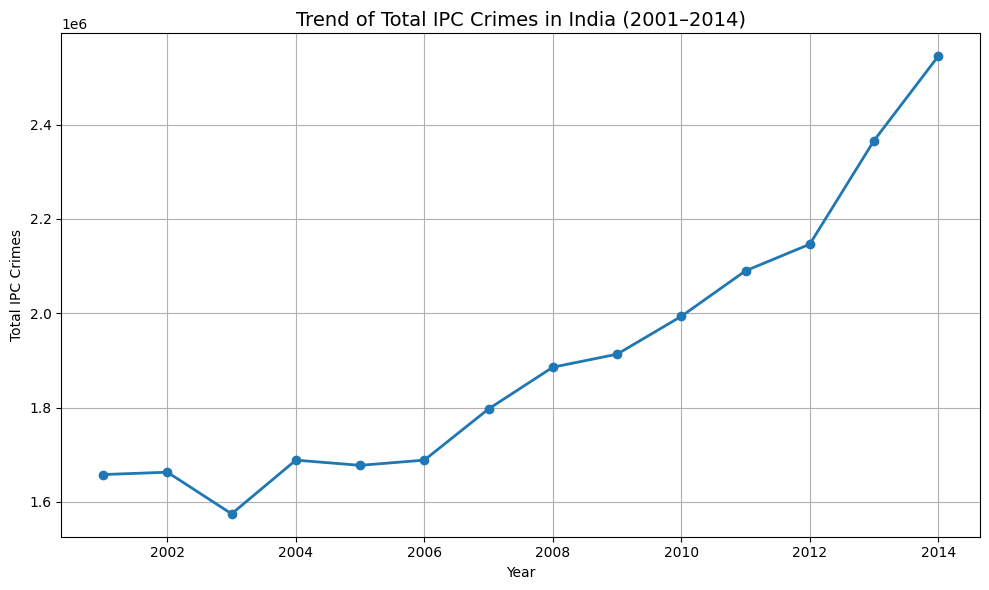

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Group data by year and sum total IPC crimes
yearly_crime_totals = df_cleaned.groupby("YEAR")["TOTAL IPC CRIMES"].sum().reset_index()

# Step 2: Plot the trend
plt.figure(figsize=(10, 6))
plt.plot(yearly_crime_totals["YEAR"], yearly_crime_totals["TOTAL IPC CRIMES"], marker='o', linewidth=2)
plt.title("Trend of Total IPC Crimes in India (2001–2014)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Total IPC Crimes")
plt.grid(True)
plt.tight_layout()
plt.show()


##**Q4 Examine if there is a link between cities and crime rates.**

In [ ]:

# Step 2: Group by district and calculate average crime rate
district_avg_crime = df_total.groupby("DISTRICT")["CRIME_RATE"].mean().reset_index()

# Step 3: Get top 10 districts by average crime rate
top_10_crime_districts = district_avg_crime.sort_values(by="CRIME_RATE", ascending=False).head(10)
top_10_crime_districts


,DISTRICT,CRIME_RATE
0,TOTAL,191.871218


##**Q5 Build a time-series model to forecast crime rates for the next five years.** **bold text**

In [ ]:
# Manually set corrected total population values
population_2001_total = (
    356152 + 76210007 + 1097968 + 26655528 + 82998509 + 900635 + 20833803 + 13850507 +
    343709 + 1347668 + 50671017 + 21144564 + 6077248 + 10143700 + 26945829 + 52850562 +
    31841374 + 60650 + 60348023 + 96878627 + 2166782 + 2306069 + 888573 + 1990036 +
    36804660 + 974345 + 24358999 + 56507188 + 540851 + 62405679 + 3199203 + 166197921 +
    8489349 + 80176197
)

population_2011_total = (
    380581 + 84665533 + 1383727 + 31205576 + 104099452 + 1055450 + 25545198 + 16787941 +
    585764 + 1458545 + 60439692 + 25351462 + 6864602 + 12541302 + 32988134 + 61095297 +
    33406061 + 64429 + 72626809 + 112374333 + 2855794 + 2966889 + 1097206 + 1978502 +
    41974218 + 1247953 + 27743338 + 68548437 + 610577 + 72147030 + 3673917 + 199812341 +
    10086292 + 91276115
)

# Step 1: Aggregate national crime totals
national_crime = df_total.groupby("YEAR")[["TOTAL IPC CRIMES"]].sum().reset_index()

# Step 2: Assign correct population per year
national_crime["POPULATION"] = national_crime["YEAR"].apply(
    lambda y: population_2001_total if y <= 2010 else population_2011_total
)

# Step 3: Calculate national crime rate
national_crime["CRIME_RATE"] = (national_crime["TOTAL IPC CRIMES"] / national_crime["POPULATION"]) * 100000

# Step 4: Model and predict future crime rate trend
X_national = national_crime[["YEAR"]]
y_national = national_crime["CRIME_RATE"]

model_national = LinearRegression()
model_national.fit(X_national, y_national)

# Predict for 2015–2025
future_years_nat = np.array(range(2015, 2026)).reshape(-1, 1)
future_predictions_nat = model_national.predict(future_years_nat)

national_future_df = pd.DataFrame({
    "YEAR": future_years_nat.flatten(),
    "PREDICTED_CRIME_RATE": future_predictions_nat
})
national_future_df

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,YEAR,PREDICTED_CRIME_RATE
0,2015,224.149645
1,2016,228.795742
2,2017,233.441838
3,2018,238.087934
4,2019,242.734030
5,2020,247.380127
6,2021,252.026223
7,2022,256.672319
8,2023,261.318415
9,2024,265.964512
